# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable ## for Plotting L.O.S Samples
import matplotlib.gridspec as gridspec

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

device:  cpu
device_count:  0
Torch version:  2.6.0+cu124
torch.version.cuda:  12.4
Is CUDA enabled? False


# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

# GASS_data_path = ml_data_path / 'GASS'
GASS_data_path = gaskap_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

# Read csv: GALAH stars with 3sigma KI detections

In [ ]:
galah_fg_df_csv_file = data_path / 'galah_fg_df_3sigma.csv'
galah_fg_df = pd.read_csv(galah_fg_df_csv_file)
galah_fg_df

In [ ]:
galah_fg_df = galah_fg_df[(galah_fg_df.yn == True) & (galah_fg_df.ew_k_is < 0.2) & (galah_fg_df.r_med > 400.) & (galah_fg_df.age > 1.) & (galah_fg_df.ebv < 1)]
galah_fg_df

sobject_id             tmass_id    gaiadr3_source_id  \
2      140811005001160  b'00000392-7323306'  4689447883087062784   
4      140711003901061  b'00000796-8126441'  4631183662419506048   
5      140711003901030  b'00001085-8105228'  4634208693785476224   
6      140711003901040  b'00001107-8109523'  4634205120372686848   
7      140711003901067  b'00001294-8134535'  4631131229458759168   
...                ...                  ...                  ...   
15578  150828004701015  b'23593935-7914094'  6352928157510667904   
15579  140711003901337  b'23594236-8005456'  6352503234922863872   
15582  141104003301215  b'23595059-7435243'  6379489613954820864   
15583  140711003901037  b'23595079-8107438'  6352328000257170048   
15584  150828004701390  b'23595454-7906171'  6352936408144528384   

         survey_name  field_id       setup        mjd          ra        dec  \
2      b'galah_main'        76  b'allstar'  56880.710    0.016250 -73.391861   
4      b'galah_main'       411  b'allstar'  56849.777    0.033167 -81.445580   
5      b'galah_main'       411  b'allstar'  56849.777    0.045208 -81.089668   
6      b'galah_main'       411  b'allstar'  56849.777    0.046167 -81.164528   
7      b'galah_main'       411  b'allstar'  56849.777    0.053917 -81.581528   
...              ...       ...         ...        ...         ...        ...   
15578  b'galah_main'       321  b'allstar'  57262.668  359.913879 -79.235970   
15579  b'galah_main'       411  b'allstar'  56849.777  359.926544 -80.096031   
15582  b'galah_main'       133  b'allstar'  56965.510  359.960754 -74.590111   
15583  b'galah_main'       411  b'allstar'  56849.777  359.961639 -81.128830   
15584  b'galah_main'       321  b'allstar'  57262.668  359.977081 -79.104752   

       flag_sp  ...          b  v_sun_projection    ki_vlsrk      l_flip  \
2            0  ... -43.233826         -7.027888   -1.188739  307.934743   
4            0  ... -35.449999         -7.127760    3.817190  305.255114   
5           88  ... -35.795691         -7.126913  -39.625753  305.359306   
6            0  ... -35.723116         -7.127265    2.524415  305.336690   
7         2112  ... -35.318838         -7.129096 -109.732138  305.211092   
...        ...  ...        ...               ...         ...         ...   
15578        0  ... -37.586190         -7.108262    2.662910  305.958509   
15579        0  ... -36.754029         -7.115741    3.941643  305.685802   
15582        0  ... -42.075811         -7.047230    8.193784  307.515543   
15583        0  ... -35.754562         -7.123348    5.670360  305.362962   
15584        0  ... -37.716183         -7.110532    5.392073  305.985627   

       lambda_k_is  rv_k_is_radio  ki_v_lsr_radio  ki_flux_std  ki_max_flux  \
2      7699.114255       5.839036       -1.188853     0.005235     0.061716   
4      7699.245377      10.944551        3.816791     0.013779     0.102848   
5      7698.129698     -32.502364      -39.629277     0.011397     0.185799   
6      7699.212165       9.651369        2.524104     0.008755     0.062491   
7      7696.329353    -102.638170     -109.767266     0.013529     0.117537   
...            ...            ...             ...          ...          ...   
15578  7699.215233       9.770853        2.662591     0.011863     0.074429   
15579  7699.248264      11.056977        3.941235     0.005069     0.096033   
15582  7699.355704      15.240239        8.193009     0.027120     0.192828   
15583  7699.292855      12.793162        5.669814     0.013037     0.081280   
15584  7699.285379      12.502084        5.391552     0.014058     0.157976   

         yn  
2      True  
4      True  
5      True  
6      True  
7      True  
...     ...  
15578  True  
15579  True  
15582  True  
15583  True  
15584  True  

[9819 rows x 196 columns]

In [ ]:
field_ids = galah_fg_df['field_id'].values
glon_fg = galah_fg_df['l'].values
glat_fg = galah_fg_df['b'].values

In [ ]:
ebv_ism_fg = galah_fg_df['ebv'].values
ew_ki_ism_fg = galah_fg_df['ew_k_is'].values
n_ki_ism_fg = np.array(compute_column_density_KI(ew_ki_ism_fg))

In [ ]:
stats_series = pd.DataFrame(n_ki_ism_fg).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

0
count  9.819000e+03
mean   1.427559e+01
std    1.068851e+01
min    1.546688e-07
25%    7.483167e+00
50%    1.100360e+01
75%    1.721271e+01
max    1.102365e+02

In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 2)
x_minval = round(series_values[3], 4)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

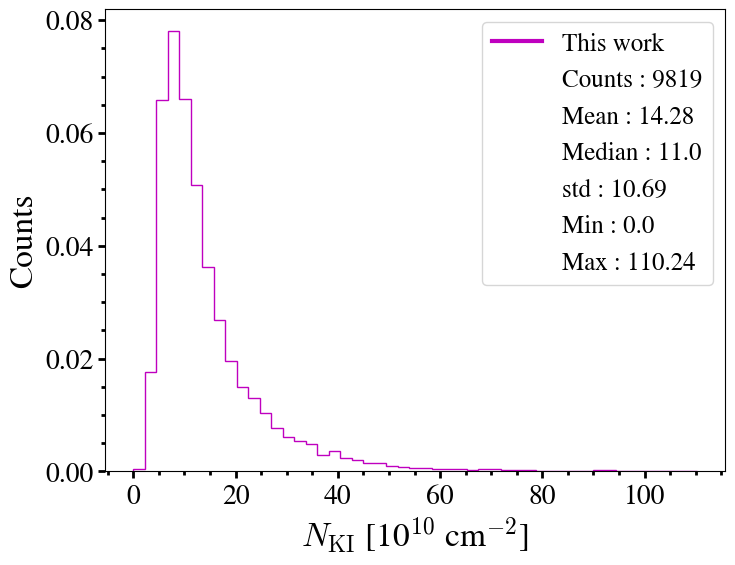

In [ ]:
# from scipy import stats

plt.figure(figsize=(8, 6))

plt.hist(n_ki_ism_fg, bins=np.linspace(np.nanmin(n_ki_ism_fg), np.nanmax(n_ki_ism_fg), 50),
         density=True, color='m', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'm-', lw=3, label=f'This work')
ploti.set_visible(True)


for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'$N_\mathrm{KI}$ [10$^{10}$ cm$^{-2}$]', fontsize=24)
plt.ylabel(r'Counts', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

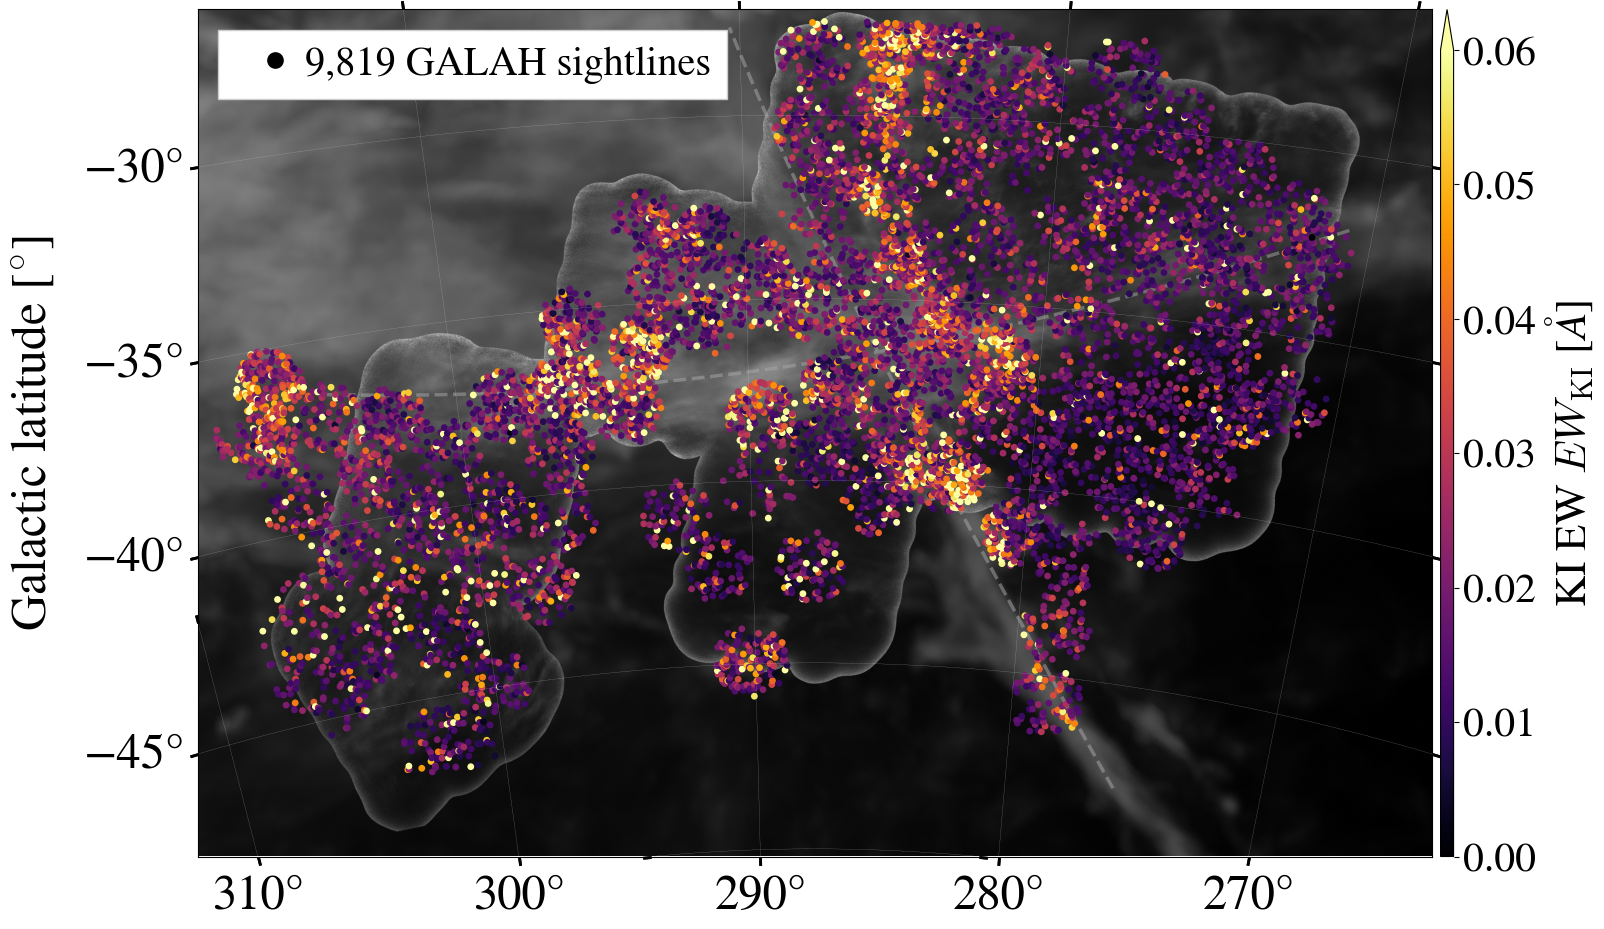

In [ ]:
xlbs = 36
tlbs = 35
cmap = 'viridis'

cm = mpl.colormaps['inferno'] # winter, cool, hsv, jet


# Plot
fig = plt.figure(figsize=(18, 11))
ax = fig.add_subplot(111, projection=tb_w)

# Display the moment map image
im = ax.imshow(tb_peak_map, cmap='gray')

sct = ax.scatter(glon_fg, glat_fg, s=15, c=ew_ki_ism_fg, transform=ax.get_transform('galactic'),
           marker='o', cmap=cm, vmin=0., vmax=0.06, # vmax=n_k_is.max(),
           label='')

ploti, = ax.plot([200], [3200], c='k', marker='o', markersize=9, mew=3, ls='', lw=0, label= "{:,} GALAH sightlines".format(len(glon_fg)))
ploti.set_visible(True)

ax.plot(ch_xcirc, ch_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label='' # Filamentary structures
       )


ax.plot(cv_xcirc, cv_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label=''
       )


# Add axes labels
ax.set_xlabel('', fontsize=xlbs)
ax.set_ylabel('Galactic latitude [$^{\circ}$]', fontsize=xlbs)

# Color bar
cbar = fig.colorbar(sct, ax=ax, extend='max', orientation='vertical', fraction=0.01, pad=0.006, aspect=65)
cbar.ax.set_ylabel('KI EW $EW_\mathrm{KI}$ [$\AA$]', rotation=90, labelpad=5., fontsize=31)
cbar.ax.tick_params(labelsize=30)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.set_ylim(0, 3500)

ax.legend(loc='upper left', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', handletextpad=-0.25, fontsize=29)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()

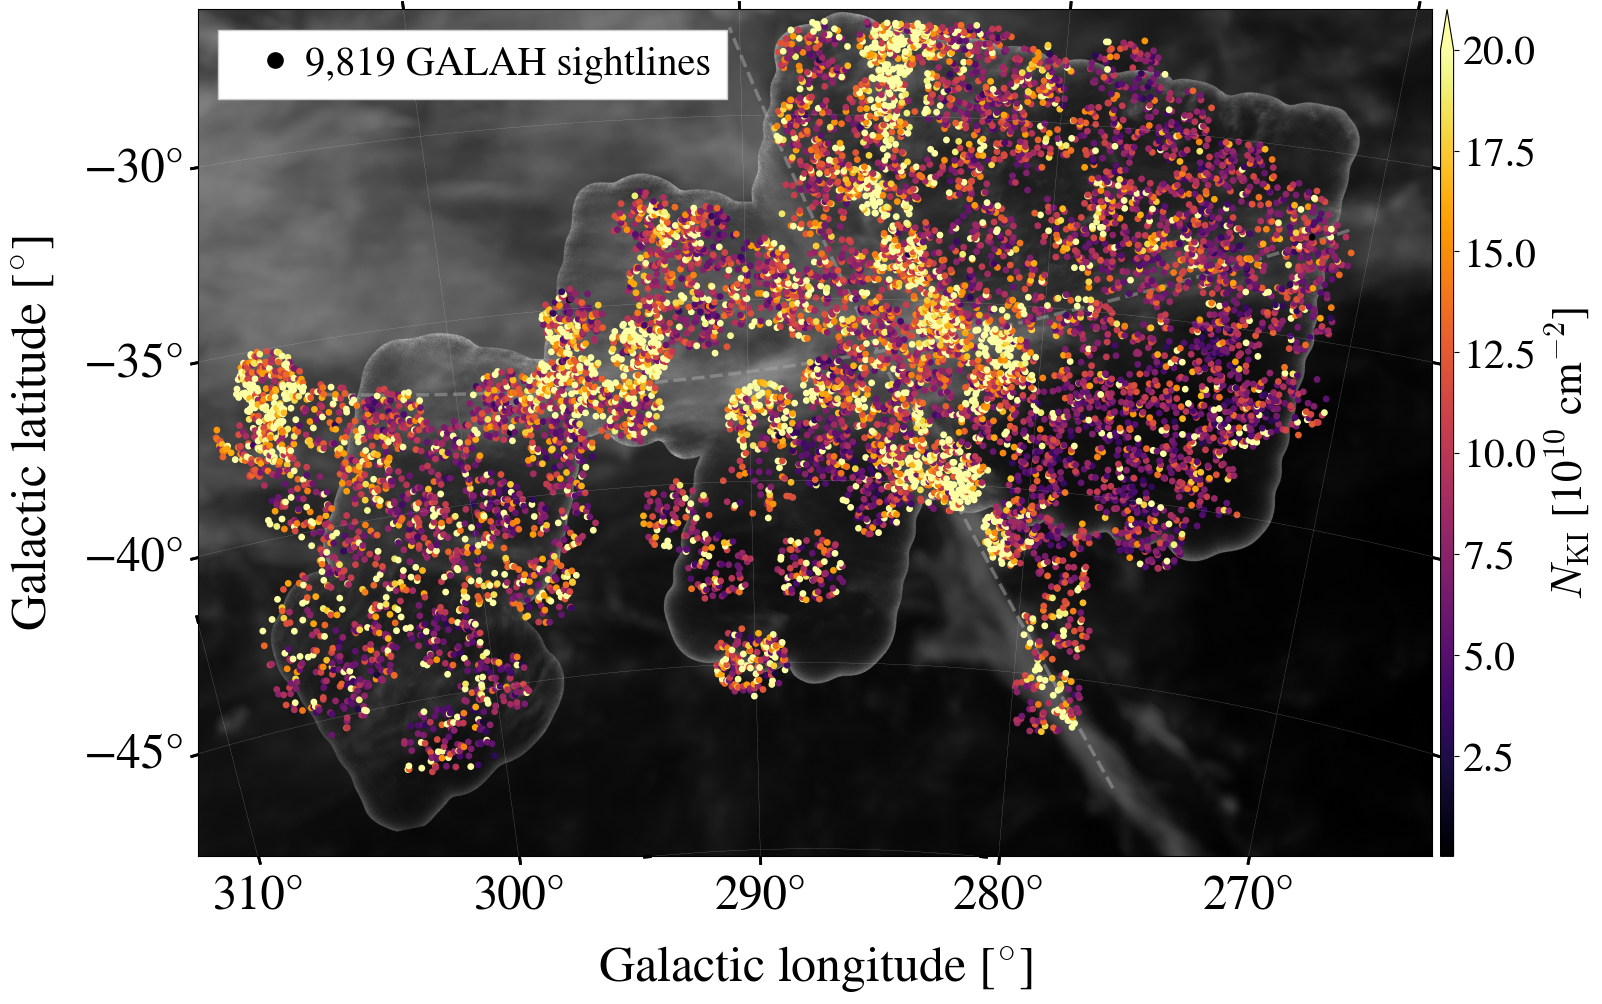

In [ ]:
xlbs = 36
tlbs = 35
cm = mpl.colormaps['inferno']


# Plot
fig = plt.figure(figsize=(18, 11))
ax = fig.add_subplot(111, projection=tb_w)

# Display the moment map image
im = ax.imshow(tb_peak_map, cmap='gray')

sct = ax.scatter(glon_fg, glat_fg, s=15, c=n_ki_ism_fg, transform=ax.get_transform('galactic'),
           marker='o', cmap=cm, vmin=n_ki_ism_fg.min(), vmax=20., # vmax=n_k_is.max(),
           label='')

ploti, = ax.plot([200], [3200], c='k', marker='o', markersize=9, mew=3, ls='', lw=0, label= "{:,} GALAH sightlines".format(len(glon_fg)))
ploti.set_visible(True)

ax.plot(ch_xcirc, ch_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label='' # Filamentary structures
       )


ax.plot(cv_xcirc, cv_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label=''
       )


# Add axes labels
ax.set_xlabel('Galactic longitude [$^{\circ}$]', fontsize=xlbs)
ax.set_ylabel('Galactic latitude [$^{\circ}$]', fontsize=xlbs)

# Color bar
cbar = fig.colorbar(sct, ax=ax, extend='max', orientation='vertical', fraction=0.01, pad=0.006, aspect=65)
cbar.ax.set_ylabel('$N_\mathrm{KI}$ [10$^{10}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=31)
cbar.ax.tick_params(labelsize=30)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.set_ylim(0, 3500)

ax.legend(loc='upper left', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', handletextpad=-0.25, fontsize=29)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()

In [ ]:
galah_gl_coords = SkyCoord(glon_fg, glat_fg, frame='galactic', unit='deg')
print(galah_gl_coords)

<SkyCoord (Galactic): (l, b) in deg
    [(307.93474265, -43.23382644), (305.2551139 , -35.44999919),
     (305.35930575, -35.79569139), ..., (307.51554317, -42.07581116),
     (305.36296221, -35.75456172), (305.98562672, -37.71618289)]>


In [ ]:
galah_x, galah_y = galah_gl_coords.to_pixel(wcs=gaskap_nhi_w)
galah_x

array([297.27029369, 369.24051058, 366.40455196, ..., 305.63774485,
       364.69254536, 346.94240317])

In [ ]:
galah_x = np.round(galah_x).astype(int)
galah_y = np.round(galah_y).astype(int)
print(galah_x)
print(galah_y)

print(galah_x[0])
print(galah_y[0])

[297 369 366 ... 306 365 347]
[ 791 2042 1986 ...  979 1993 1680]
297
791


In [ ]:
gaskap_nhi_thin = np.zeros_like(ew_ki_ism_fg)
for jj, (galah_xi, galah_yi) in enumerate(zip(galah_x, galah_y)):
    gaskap_nhi_thin[jj] = gaskap_nhi[galah_yi, galah_xi]

In [ ]:
# import scipy
statpr, statpp = scipy.stats.pearsonr(gaskap_nhi_thin, n_ki_ism_fg)
statspr, statspp = scipy.stats.spearmanr(gaskap_nhi_thin, n_ki_ism_fg)
print('nhi vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhi vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhi vs nki: pearson coefficient, statistic = 0.24009303418469463 , p-value = 9.071170230452132e-129
nhi vs nki: spearman coefficient, statistic = 0.3397862272190992 , p-value = 7.078679264418808e-264


# Tb peak

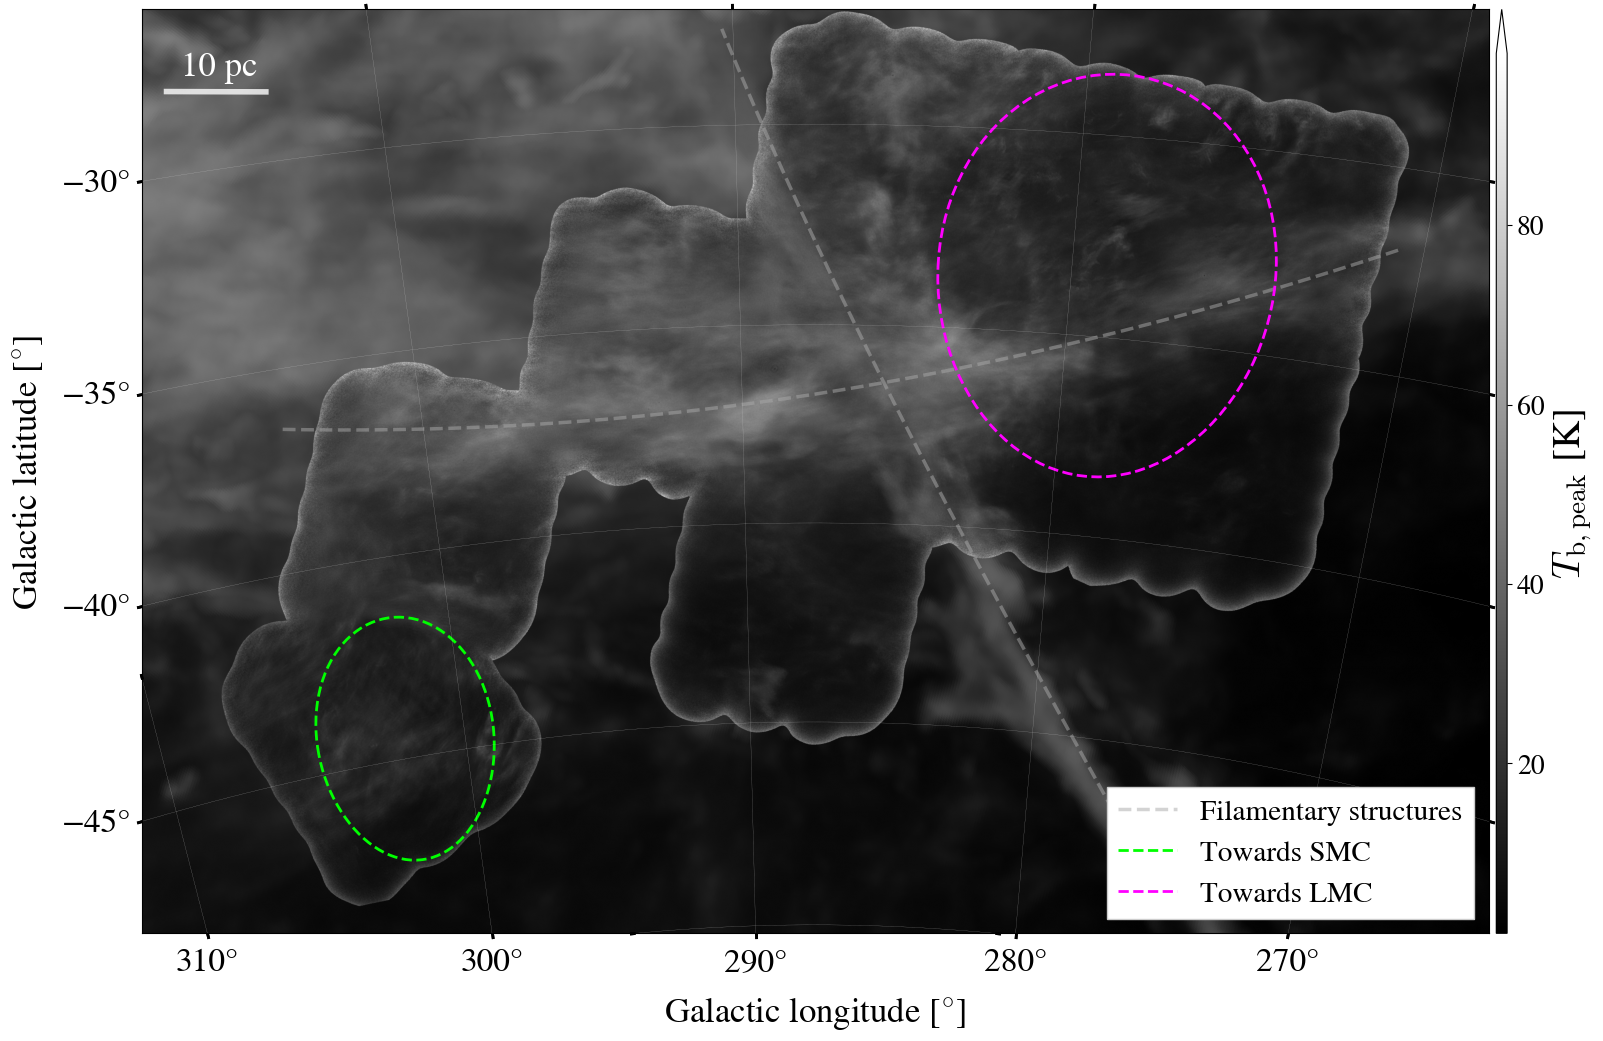

In [ ]:
# Plot
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection=tb_w)

# Display the moment map image
im = ax.imshow(tb_peak_map, cmap='gray')

ax.plot(ch_xcirc, ch_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label='Filamentary structures'
       )


ax.plot(cv_xcirc, cv_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label=''
       )


# # Approximate locations of LMC, SMC
ax.plot(SMC_xcirc,
        SMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='lime',
        ls='--',
        label='Towards SMC'
       )
ax.plot(LMC_xcirc,
        LMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='fuchsia',
        ls='--',
        label='Towards LMC'
       )


ax.plot([303., 305.6], [-28.33, -28.], transform=ax.get_transform('galactic'), c='white', lw=4, alpha=0.8, label=f'')
ax.text(304.1, -27.6, '10 pc', dict(size=25, color='white'), horizontalalignment='center',  verticalalignment='center', transform=ax.get_transform('galactic'))



# Add axes labels
ax.set_xlabel("Galactic Longitude [degrees]", fontsize=16)
ax.set_ylabel("Galactic Latitude [degrees]", fontsize=16)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', extend='max', fraction=0.008, pad=0.005, aspect=85)
cbar.ax.set_ylabel('$T_\mathrm{b,peak}$ [K]', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=20)


# Add axes labels
ax.set_xlabel(r'Galactic longitude [$^{\circ}$]', fontsize=25)
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=25)

ax.tick_params(axis='x', labelsize=24, pad=4)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.legend(loc='lower right', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', fontsize=21)
ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()

In [ ]:
galah_x, galah_y = galah_gl_coords.to_pixel(wcs=tb_w)
galah_x

array([297.27029369, 369.24051058, 366.40455196, ..., 305.63774485,
       364.69254536, 346.94240317])

In [ ]:
galah_x = np.round(galah_x).astype(int)
galah_y = np.round(galah_y).astype(int)
print(galah_x)
print(galah_y)

print(galah_x[0])
print(galah_y[0])

[297 369 366 ... 306 365 347]
[ 791 2042 1986 ...  979 1993 1680]
297
791


In [ ]:
gaskap_tb_peak_arr = np.zeros_like(ew_ki_ism_fg)
for jj, (galah_xi, galah_yi) in enumerate(zip(galah_x, galah_y)):
    gaskap_tb_peak_arr[jj] = tb_peak_map[galah_yi, galah_xi]

In [ ]:
# import scipy
statpr, statpp = scipy.stats.pearsonr(gaskap_tb_peak_arr, n_ki_ism_fg)
statspr, statspp = scipy.stats.spearmanr(gaskap_tb_peak_arr, n_ki_ism_fg)
print('tbpeak vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('tbpeak vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

tbpeak vs nki: pearson coefficient, statistic = 0.2318259622310181 , p-value = 6.026592479626482e-120
tbpeak vs nki: spearman coefficient, statistic = 0.31166756243634663 , p-value = 3.823814741456028e-220


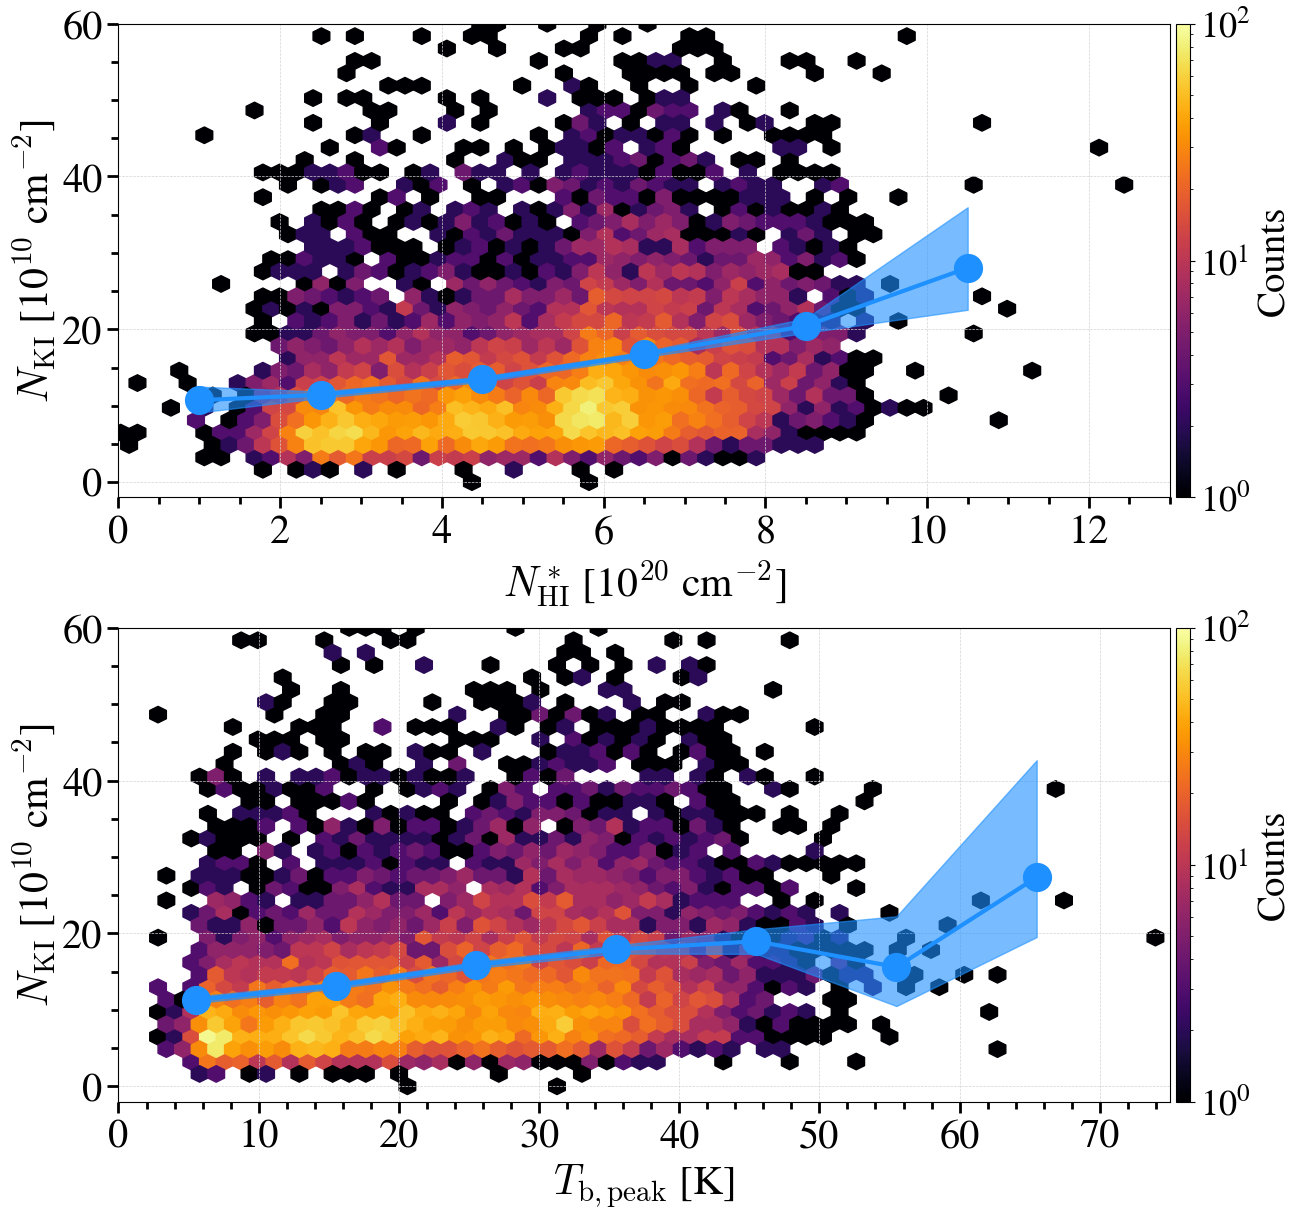

In [ ]:
xlbs = 25
tlbs = 23
cmap = 'viridis'

cm = mpl.colormaps['cool'] # winter, cool, hsv, jet


# Plot
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(211) # projection=w

bin_edges = [0.5, 2, 4, 6, 8, 10, 12]
bin_avg, bin_avg_upper, bin_avg_lower = binned_avg(gaskap_nhi_thin[sel_idx], n_ki_ism_fg[sel_idx], bin_edges)
x_bin = np.array(bin_edges[:-1]) + 0.5



normalizer = LogNorm(1., 100)
img = ax.hexbin(gaskap_nhi_thin[sel_idx], n_ki_ism_fg[sel_idx], gridsize=60, cmap='inferno', norm=normalizer, zorder=1)


ax.plot(x_bin, bin_avg,
                   zorder=3,
                   marker='o', c='dodgerblue', markersize=20,
                   ls='-', lw=3,
                   label='')

ax.fill_between(x_bin, bin_avg_upper, bin_avg_lower, color='dodgerblue', zorder=2, alpha=0.6, lw=1, label='')



# Add axes labels
ax.set_ylabel(r'$N_\mathrm{KI}$ [10$^{10}$ cm$^{-2}$]', fontsize=30)
ax.set_xlabel(r'$N^*_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=30, fontweight='normal')


ax.minorticks_on()
ax.tick_params(axis='x', labelsize=29, pad=4)
ax.tick_params(axis='y', labelsize=29)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)

ax.set_xlim(0., 13)
ax.set_ylim(-2, 60)

# Color bar
cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'Counts', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=26)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)










################
ax = fig.add_subplot(212) # projection=w

bin_edges = [5, 15, 25, 35, 45, 55, 65, 75]
bin_avg, bin_avg_upper, bin_avg_lower = binned_avg(gaskap_tb_peak_arr[sel_idx], n_ki_ism_fg[sel_idx], bin_edges)
x_bin = np.array(bin_edges[:-1]) + 0.5


normalizer = LogNorm(1., 100)
img = ax.hexbin(gaskap_tb_peak_arr[sel_idx], n_ki_ism_fg[sel_idx], gridsize=60, cmap='inferno', norm=normalizer)

ax.plot(x_bin, bin_avg,
                   zorder=3,
                   marker='o', c='dodgerblue', markersize=20,
                   ls='-', lw=3,
                   label='')

ax.fill_between(x_bin, bin_avg_upper, bin_avg_lower, color='dodgerblue', zorder=2, alpha=0.6, lw=1, label='')



# Add axes labels
ax.set_ylabel(r'$N_\mathrm{KI}$ [10$^{10}$ cm$^{-2}$]', fontsize=30)
ax.set_xlabel(r'$T_\mathrm{b,peak}$ [K]', fontsize=30, fontweight='normal')


ax.minorticks_on()
ax.tick_params(axis='x', labelsize=29, pad=4)
ax.tick_params(axis='y', labelsize=29)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)

ax.set_xlim(0., 75)
ax.set_ylim(-2, 60)

# Color bar
cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'Counts', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=26)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.,
                    hspace=0.275
                    )



plt.show()